In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

df = pd.read_csv("../data/ETTh1.csv")
df['date'] = pd.to_datetime(df['date'])

P_high = np.sqrt(df['HUFL']**2 + df['HULL']**2)
P_mid  = np.sqrt(df['MUFL']**2 + df['MULL']**2)
P_low  = np.sqrt(df['LUFL']**2 + df['LULL']**2)


In [2]:
# WINDOWING & STATISTICAL FEATURE ENGINEERING

def create_windowed_features(df, window_sizes=[6, 12, 24]):

    base_features = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']
    results = {}

    for window in window_sizes:
        print(f"\nProcessing window size: {window} hours")

        new_cols = {}

        # Rolling statistics
        for feat in base_features:
            roll = df[feat].rolling(window, min_periods=1)

            new_cols[f'{feat}_mean_{window}h']  = roll.mean()
            new_cols[f'{feat}_std_{window}h']   = roll.std().fillna(0)
            new_cols[f'{feat}_min_{window}h']   = roll.min()
            new_cols[f'{feat}_max_{window}h']   = roll.max()
            new_cols[f'{feat}_range_{window}h'] = (
                new_cols[f'{feat}_max_{window}h']
                - new_cols[f'{feat}_min_{window}h']
            )

        # Power features
        new_cols[f'P_high_mean_{window}h'] = P_high.rolling(window, min_periods=1).mean()
        new_cols[f'P_mid_mean_{window}h']  = P_mid.rolling(window, min_periods=1).mean()
        new_cols[f'P_low_mean_{window}h']  = P_low.rolling(window, min_periods=1).mean()

        # Rate of change
        new_cols[f'OT_roc_{window}h']       = df['OT'].diff(window).fillna(0)
        new_cols[f'P_high_roc_{window}h']   = P_high.diff(window).fillna(0)

        # CONCAT ONCE (critical)
        df_window = pd.concat([df, pd.DataFrame(new_cols)], axis=1)

        # De-fragment memory explicitly
        results[window] = df_window.copy()

    return results

# Create windowed features
windowed_dfs = create_windowed_features(df.copy())


Processing window size: 6 hours

Processing window size: 12 hours

Processing window size: 24 hours


In [3]:
def evaluate_window_size(windowed_dfs, eps_optimal):
    
    # Evaluate which window size produces best clustering

    scores = {}
    
    for window, df_temp in windowed_dfs.items():
        # Select windowed features for this window size
        feature_cols = [col for col in df_temp.columns 
                       if f'_{window}h' in col and 'OT' not in col]
        
        X_window = df_temp[feature_cols].values
        
        # Standardize
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_window)
        
        # Run DBSCAN
        clustering = DBSCAN(eps=eps_optimal, min_samples=5)
        labels = clustering.fit_predict(X_scaled)
        
        # Calculate metrics
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_ratio = np.mean(labels == -1)
        
        # Silhouette score (only if we have clusters)
        if n_clusters > 1:
            # Filter out noise points for silhouette calculation
            mask = labels != -1
            if mask.sum() > 10:  # Need enough points
                sil_score = silhouette_score(X_scaled[mask], labels[mask])
            else:
                sil_score = -1
        else:
            sil_score = -1
        
        scores[window] = {
            'n_clusters': n_clusters,
            'noise_ratio': noise_ratio,
            'silhouette': sil_score,
            'X_scaled': X_scaled,
            'labels': labels
        }
        
        print(f"\nWindow {window}h: Clusters={n_clusters}, "
              f"Noise={noise_ratio:.2%}, Silhouette={sil_score:.3f}")
    
    # Select best window (highest silhouette score)
    best_window = max(scores.keys(), key=lambda k: scores[k]['silhouette'])
    print(f"\n✓ Best window size: {best_window} hours")
    
    return best_window, scores

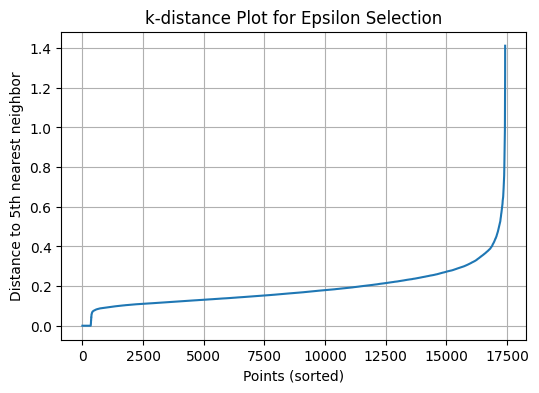

In [4]:
# We are trying to find the ideal value of epsilon in this block of code.

features = np.c_[P_high, P_mid, P_low, df['OT']]
scaler = StandardScaler()
X = scaler.fit_transform(features)

k = 5
nbrs = NearestNeighbors(n_neighbors=k)
nbrs.fit(X)

distances, _ = nbrs.kneighbors(X)

k_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(6,4))
plt.plot(k_distances)
plt.xlabel("Points (sorted)")
plt.ylabel(f"Distance to {k}th nearest neighbor")
plt.title("k-distance Plot for Epsilon Selection")
plt.grid()
plt.show()

The elbow in the k-distance plot provides a heuristic for selecting ε.

In [5]:
# Calculating the ideal value of epsilon

x = np.arange(len(k_distances))
y = k_distances

# Line between first and last point
point1 = np.array([x[0], y[0]])
point2 = np.array([x[-1], y[-1]])

# Compute perpendicular distances
distances_to_line = np.abs(
    np.cross(point2 - point1, point1 - np.vstack((x, y)).T)
) / np.linalg.norm(point2 - point1)

# Elbow index
elbow_index = np.argmax(distances_to_line)
eps_optimal = k_distances[elbow_index]

print("Optimal epsilon value = ",eps_optimal)

Optimal epsilon value =  0.3306203218397205


In [6]:
best_window, window_scores = evaluate_window_size(windowed_dfs, eps_optimal)
df_best = windowed_dfs[best_window]

# Ridge regression on windowed features
feature_cols = [col for col in df_best.columns 
               if f'_{best_window}h' in col and 'OT' not in col]
X_ridge = StandardScaler().fit_transform(df_best[feature_cols])

reg = Ridge(alpha=1.0)
reg.fit(X_ridge, df_best['OT'])
df_best['OT_pred'] = reg.predict(X_ridge)
df_best['residual'] = df_best['OT'] - df_best['OT_pred']

# Residual-based anomaly detection
median = np.median(df_best['residual'])
mad = np.median(np.abs(df_best['residual'] - median))
mad = max(mad, 1e-6)
res_anomaly = np.abs(df_best['residual'] - median) > 3 * mad


Window 6h: Clusters=15, Noise=98.20%, Silhouette=0.996

Window 12h: Clusters=17, Noise=98.65%, Silhouette=0.992

Window 24h: Clusters=411, Noise=81.84%, Silhouette=0.757

✓ Best window size: 6 hours


In [7]:

ot_threshold = df_best['OT'].quantile(0.85)   # top 15% of temperatures

# Physics-aware anomaly mask (high-OT only)
anomaly_mask = (df_best['cluster'] == -1) & (df_best['OT'] >= ot_threshold)

# noise statistics
dbscan_noise_count = (df_best['cluster'] == -1).sum()
dbscan_noise_ratio = np.mean(df_best['cluster'] == -1)

final_anomaly = (
    (df_best['cluster'] == -1) &
    (df_best['OT'] >= ot_threshold) &
    res_anomaly
)

KeyError: 'cluster'

In [ ]:
# Plotting the outliers
plt.figure(figsize = (12,4))
plt.plot(df_best['date'], df_best['OT'], label = 'OT vs Date')

plt.scatter(
    df.loc[final_anomaly, 'date'], df.loc[final_anomaly, 'OT'], color='red', s=10, label='Anomalies'
)

plt.axhline(
    ot_threshold,
    color='gray',
    linestyle='--',
    linewidth=1,
    label='High-OT Threshold'
)

plt.xlabel('Date')
plt.ylabel('OT')
plt.legend()
plt.show()

DBSCAN helps detect rare states

Ridge Regression helps detect unexpected responses

The "final_anomaly" basically identifies a rare operating point which also violates expected thermal behavior.

In [ ]:
print("ANOMALY DETECTION RESULTS")

# DBSCAN statistics
n_clusters = len(set(df_best['cluster'])) - (1 if -1 in df_best['cluster'] else 0)
print(f"\nDBSCAN Clustering:")
print(f"  Clusters found: {n_clusters}")
print(f"  Noise points: {dbscan_noise_count} ({dbscan_noise_ratio*100:.2f}%)")

# Residual statistics
print(f"\nResidual Analysis:")
print(f"  Median residual: {median:.4f}")
print(f"  MAD: {mad:.4f}")
print(f"  Threshold (3×MAD): ±{3*mad:.4f}")
print(f"  High residual points: {res_anomaly.sum()} ({res_anomaly.mean()*100:.2f}%)")

# Final anomalies
print(f"\nFinal Anomalies (All criteria):")
print(f"  Count: {final_anomaly.sum()}")
print(f"  Percentage: {final_anomaly.mean()*100:.2f}%")

# Save for analysis
df_best[final_anomaly].to_csv('detected_anomalies.csv', index=False)
print(f"\nAnomalies saved to 'detected_anomalies.csv'")